# **IMPUTACION ESPACIOTEMPORAL DE SERIES DE PRECIPITACION**
En este notebook se realiza la imputacion de datos en la serie de precipitacion del CCCP con series de precipitacion de la base de datos de CHIRPS  para poder tener una serie continua, se utilizan modelos estacionarios como SARIMA

## **Proceso ETL**
---
## 1. Datos de la Red MPOMM
- Obtencion de los datos de la serie de precipitaicond e la base de datos de Red_MPOMM

In [1]:
from api_somo import DataFetcher, fetch_qf 
import logging

# Setting up logging for the main script
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

api_url = "http://127.0.0.1:8000/database/filter-serie/"
params = {
    "station_name": "tumaco",
    "variable_name": "Precipitación acumulada",
    "processing_level_name": "Control de calidad",
    "start_date":"2010-01-01",
    "end_date":"2012-12-31"
    }

try:
    # 1. Fetch and process the data
    red_mpomm_serie = DataFetcher.fetch_and_process_data(api_url, params)

    if red_mpomm_serie.empty:
        raise ValueError("The historical series is empty.")

    # Additional processing with the historical series
    logger.info(f"Fetched historical series: {red_mpomm_serie.head(0)}")

except Exception as e:
    logger.error(f"Error fetching historical series: {e}")


display(red_mpomm_serie)

INFO:api_somo:Sending request to http://127.0.0.1:8000/database/filter-serie/ with parameters: {'station_name': 'tumaco', 'variable_name': 'Precipitación acumulada', 'processing_level_name': 'Control de calidad', 'start_date': '2010-01-01', 'end_date': '2012-12-31'}
INFO:api_somo:Original columns: ['date_time', 'sensor_data', 'quality_flag', 'latitude', 'longitude']
INFO:api_somo:Columns after renaming: ['timestamp', 'value', 'qf', 'latitude', 'longitude']
INFO:api_somo:Timestamp conversion and indexing complete.
INFO:__main__:Fetched historical series: Empty DataFrame
Columns: [value, qf, latitude, longitude]
Index: []


,value,qf,latitude,longitude
timestamp,,,,
2010-01-01 05:00:00+00:00,0.0,1,1.82011,-78.72871
2010-01-01 05:10:00+00:00,0.0,1,1.82011,-78.72871
2010-01-01 05:20:00+00:00,0.0,1,1.82011,-78.72871
2010-01-01 05:30:00+00:00,0.0,1,1.82011,-78.72871
2010-01-01 05:40:00+00:00,0.0,1,1.82011,-78.72871
...,...,...,...,...
2012-12-31 04:20:00+00:00,0.1,1,1.82011,-78.72871
2012-12-31 04:30:00+00:00,0.0,1,1.82011,-78.72871
2012-12-31 04:40:00+00:00,0.1,1,1.82011,-78.72871


In [2]:
from graphics_utils.express import fig_pie_month
pie_fig = fig_pie_month(red_mpomm_serie, params)
pie_fig.show()

### ETL-Red MPOMM
- Preprocesamiento de los datos de la redmpomm

- Se convierten a nan los datos que tienen bandera de calidad distinta de 'bueno' y se realiza un reporte de cuantos datos nulos quedaron

In [3]:
import numpy as np
red_mpomm_serie.loc[~red_mpomm_serie['qf'].isin([1, 3]), 'value'] = np.nan
#Muestra cuantas celdas con datos nulos o faltantes tiene cada columna de la base de datos
red_mpomm_serie.isnull().sum()

value        13089
qf               0
latitude         0
longitude        0
month            0
year             0
dtype: int64

- Se realiza un remuestreo con la funcion predeterminada, y se vuelve a remplazar con nan los datos que tengan calidad distinta a 'bueno'

In [4]:
from utils.utils import reshample_time_serie
serie_resample=reshample_time_serie(red_mpomm_serie, nueva_frecuencia='D', metodo='sum')
display(serie_resample.columns)
# Aplicar la condición para reemplazar 'value' con NaN si 'qf' no es 1
serie_resample['value'] = serie_resample['value'].where(serie_resample['qf'] == 1, np.nan)
serie_resample


Index(['value', 'qf', 'latitude', 'longitude', 'month', 'year'], dtype='object')

,value,qf,latitude,longitude,month,year
timestamp,,,,,,
2010-01-01,0.0,1,1.82011,-78.72871,1,2010
2010-01-02,0.0,1,1.82011,-78.72871,1,2010
2010-01-03,4.1,1,1.82011,-78.72871,1,2010
2010-01-04,0.4,1,1.82011,-78.72871,1,2010
2010-01-05,0.3,1,1.82011,-78.72871,1,2010
...,...,...,...,...,...,...
2012-12-27,0.0,1,1.82011,-78.72871,12,2012
2012-12-28,0.0,1,1.82011,-78.72871,12,2012
2012-12-29,0.0,1,1.82011,-78.72871,12,2012


- Muestra la cantidad de Nan en el dataset
- Crear el dataset de trabajo

In [5]:
import pandas as pd

dataset = serie_resample['value'].to_frame()

display(dataset.isnull().sum())

# Mostrar el resultado
display(dataset)



value    175
dtype: int64

,value
timestamp,
2010-01-01,0.0
2010-01-02,0.0
2010-01-03,4.1
2010-01-04,0.4
2010-01-05,0.3
...,...
2012-12-27,0.0
2012-12-28,0.0
2012-12-29,0.0


## 2. Datos de CIRPS

### Obtener los datos del data warehouse
- En este df se extraen los datos mas cercanos al punto al cual se le realiza la imputacion, la inspeccion fue visual para determinar dichos puntos 

In [6]:
from pymongo import MongoClient
from pymongo.errors import ConnectionFailure, OperationFailure
import pandas as pd

try:
    # Conexión a MongoDB
    print("Intentando conectar a MongoDB...")
    client = MongoClient('localhost', 27017)  # Cambia los parámetros si es necesario
    print("Conexión a MongoDB exitosa.")

    # Selecciona la base de datos y la colección
    db = client['CHIRPS']
    collection = db['sensor_data']

    print(client['EVC-SOMMO'].list_collection_names())  # Lista las colecciones de la base de datos


    # Consulta para obtener todos los documentos de la colección
    print("Obteniendo documentos de la colección...")
    data = collection.find()  # Esto devuelve un cursor iterable

    # Convertir el cursor a una lista
    data_list = list(data)

    if not data_list:
        print("No se encontraron documentos.")
    else:
        # Crear listas para almacenar los datos extraídos
        points = []
        timestamps = []

        # Recorrer los documentos y extraer los datos relevantes
        for document in data_list:
            timestamp = document.get('timestamp')  # Extrae el timestamp
            points_data = document.get('point_data', [])  # Extrae el array de puntos

            for point in points_data:
                point_dict = {
                    'point_id': point.get('point_id'),
                    'latitude': point.get('latitude'),
                    'longitude': point.get('longitude'),
                    'value': point.get('value'),
                    'timestamp': timestamp  # Incluir timestamp para cada punto
                }
                points.append(point_dict)

        # Convertir los puntos a un DataFrame
        print(f"Se encontraron {len(points)} puntos. Convirtiendo a DataFrame...")
        df = pd.DataFrame(points)

        # Si la colección tiene un campo '_id', lo eliminamos para evitar problemas
        if '_id' in df.columns:
            df = df.drop(columns=['_id'])
        
        # Filtrar los puntos deseados
        selected_points = ['point_6', 'point_10', 'point_12']
        df = df[df['point_id'].isin(selected_points)]

        # Mostrar las primeras filas del DataFrame
        print("DataFrame creado con éxito:")
        display(df.head(5))

except ConnectionFailure as e:
    print(f"Error al conectar con MongoDB: {e}")
except OperationFailure as e:
    print(f"Error en la operación de MongoDB: {e}")
except Exception as e:
    print(f"Error inesperado: {e}")


Intentando conectar a MongoDB...
Conexión a MongoDB exitosa.
[]
Obteniendo documentos de la colección...
Se encontraron 60996 puntos. Convirtiendo a DataFrame...
DataFrame creado con éxito:


,point_id,latitude,longitude,value,timestamp
5,point_6,1.774998,-78.725006,0.000000,2009-02-01
9,point_10,1.824997,-78.725006,0.000000,2009-02-01
11,point_12,1.824997,-78.775000,0.000000,2009-02-01
17,point_6,1.774998,-78.725006,0.000000,2009-02-02
21,point_10,1.824997,-78.725006,12.457714,2009-02-02


### ETL-CHIRPS
- Transformacion del formato, se extraen las series temporales continuas y que coinciden con la marca de tiempo, esto se realiza para obtener el formato para añadir al dataset de trabajo

In [7]:
import pandas as pd

# Suponiendo que df es tu dataset original
df['timestamp'] = pd.to_datetime(df['timestamp'])  # Asegurar que sea datetime

# Crear la tabla pivotante con fecha como índice y cada punto como columna
df_pivot = df.pivot_table(index='timestamp', columns='point_id', values='value')

# Mostrar el DataFrame resultante
display(df_pivot)



point_id,point_10,point_12,point_6
timestamp,,,
2009-02-01,0.000000,0.000000,0.000000
2009-02-02,12.457714,16.109703,0.000000
2009-02-03,12.457714,16.109703,29.260645
2009-02-04,0.000000,0.000000,0.000000
2009-02-05,0.000000,0.000000,0.000000
...,...,...,...
2022-12-28,0.000000,0.000000,7.627149
2022-12-29,0.000000,0.000000,0.000000
2022-12-30,0.000000,0.000000,11.136356


- Se filtran y vuelven nan los datos que superan el umbral 

In [8]:
# Reemplazar los valores mayores a 500 por NaN
df_pivot = df_pivot.mask(df_pivot > 500)
#Muestra cuantas celdas con datos nulos o faltantes tiene cada columna de la base de datos
df_pivot.isnull().sum()


point_id
point_10    1
point_12    0
point_6     6
dtype: int64

## **Analisis de los datos**
---
### Dataset
- Se añade al dataset los datos de CHIRPS y se calcula las dimenciones del dataset

In [9]:
# Convertir el índice de df_pivot a naive (sin zona horaria)
df_pivot.index = df_pivot.index.tz_localize(None)

# Si dataset también tiene una columna de fecha, conviértela a datetime sin zona horaria
dataset.index = pd.to_datetime(dataset.index).tz_localize(None)

# Intentar unir los DataFrames nuevamente
dataset = dataset.join(df_pivot, how='inner')
display(dataset.shape)
dataset


(1096, 4)

,value,point_10,point_12,point_6
timestamp,,,,
2010-01-01,0.0,0.0000,0.000000,0.000000
2010-01-02,0.0,0.0000,0.000000,0.000000
2010-01-03,4.1,0.0000,0.000000,0.000000
2010-01-04,0.4,0.0000,0.000000,0.000000
2010-01-05,0.3,0.0000,0.000000,0.000000
...,...,...,...,...
2012-12-27,0.0,0.0000,0.000000,0.000000
2012-12-28,0.0,0.0000,0.000000,0.000000
2012-12-29,0.0,0.0000,0.000000,0.000000


### Graficar las series temporales
- Se grafican las series del dataset para tener una vision general del comportamiento de cada una

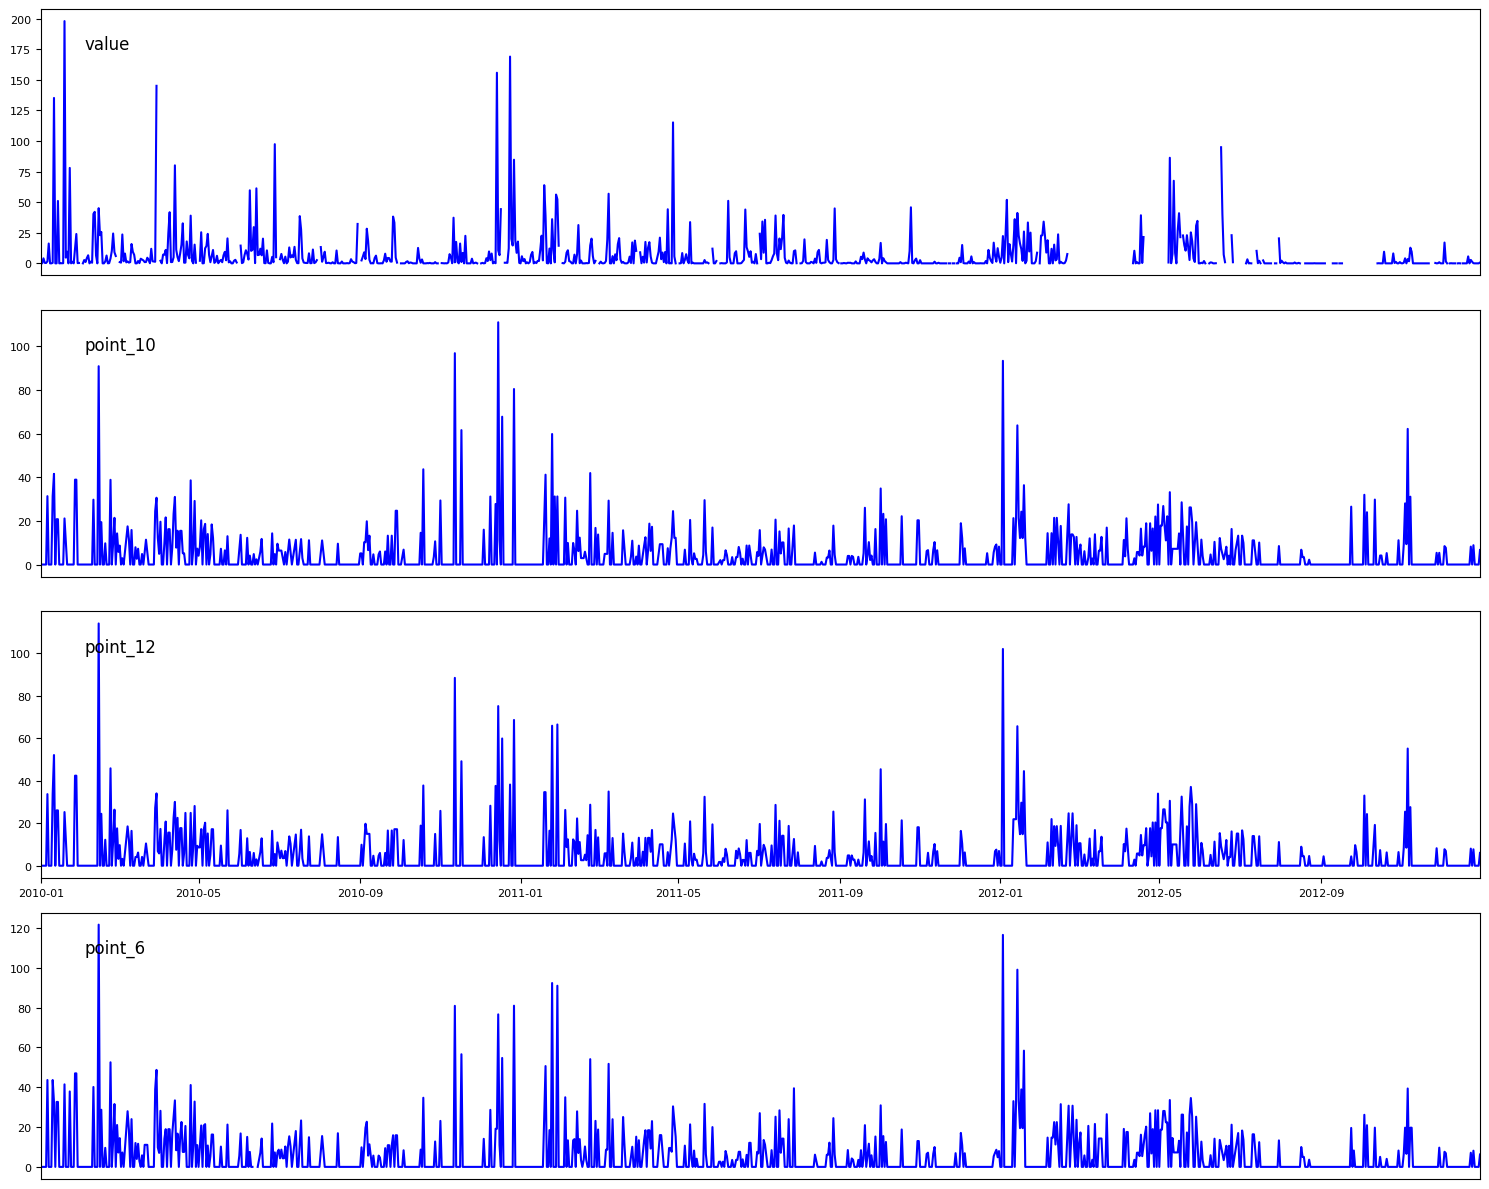

In [10]:
import matplotlib.pyplot as plt
# Gráficar
fig, axs = plt.subplots(nrows=dataset.shape[1], ncols=1, figsize=(15, 12)) # Ajustar el número de "nrows" por el número de columnas a gráficar
for i, col in enumerate(dataset.columns[0:]):
    fila = i
    columna = 0
    ax = axs[fila]
    ax.plot(dataset.index, dataset[col], color='blue')
    ax.set_ylabel('', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_xlim(dataset.index.min(), dataset.index.max())
    ax.text(0.03, 0.85, col, transform=ax.transAxes, fontsize=12)
    if i != len(dataset.columns[1:]) - 1:
        ax.set_xticks([])
    else:
        ax.set_xlabel('', fontsize=6)
plt.subplots_adjust(hspace=0.05)
plt.tight_layout()
plt.show()

### Grafico espacial
- estracion de coordenadas.

Se extraen las coordenadas de mongo y de la serie de la red mpomm de manera dinamica.

In [ ]:
# Extraer las ubicaciones únicas
locations_df = df[['latitude', 'longitude']].drop_duplicates().reset_index(drop=True)

# Convertir red_mpomm_serie[0] en un DataFrame (si no lo es)
new_locations = pd.DataFrame(red_mpomm_serie[['latitude', 'longitude']].drop_duplicates())

# Concatenar ambos DataFrames y eliminar duplicados
locations_df = pd.concat([locations_df, new_locations]).drop_duplicates().reset_index(drop=True)

# Mostrar el resultado
print(locations_df)



   latitude  longitude
0  1.774998 -78.725006
1  1.824997 -78.725006
2  1.824997 -78.775000
3  1.820110 -78.728710


- Se crea el mapa y se grafican los puntos que estan disponibles

In [12]:
import folium

# Crear el mapa centrado en la ubicación promedio
map_center = [locations_df['latitude'].mean(), locations_df['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=6)

# Agregar marcadores al mapa
for _, row in locations_df.iterrows():
    folium.Marker(location=[row['latitude'], row['longitude']],
                popup=f"Lat: {row['latitude']}, Lon: {row['longitude']}").add_to(m)

# Mostrar el mapa (en un entorno compatible como Jupyter Notebook)
m


### Correlaciones entre los datos
- Ajustamos los datos eliminando los nan y garantizamos que la matriz sea cuadrada para su trabajo

In [13]:
# Crear un dataframe con solo las filas con datos en todas las columnas
dataset_no_nan = dataset.dropna()
dataset_no_nan.shape

(919, 4)

- grafico de las series continuas 

Inspeccion visual del estado de las series que se encuentran en el dataset ademas de un informe numerico para corroborar la inexistencia de registros nan.

value       0
point_10    0
point_12    0
point_6     0
dtype: int64

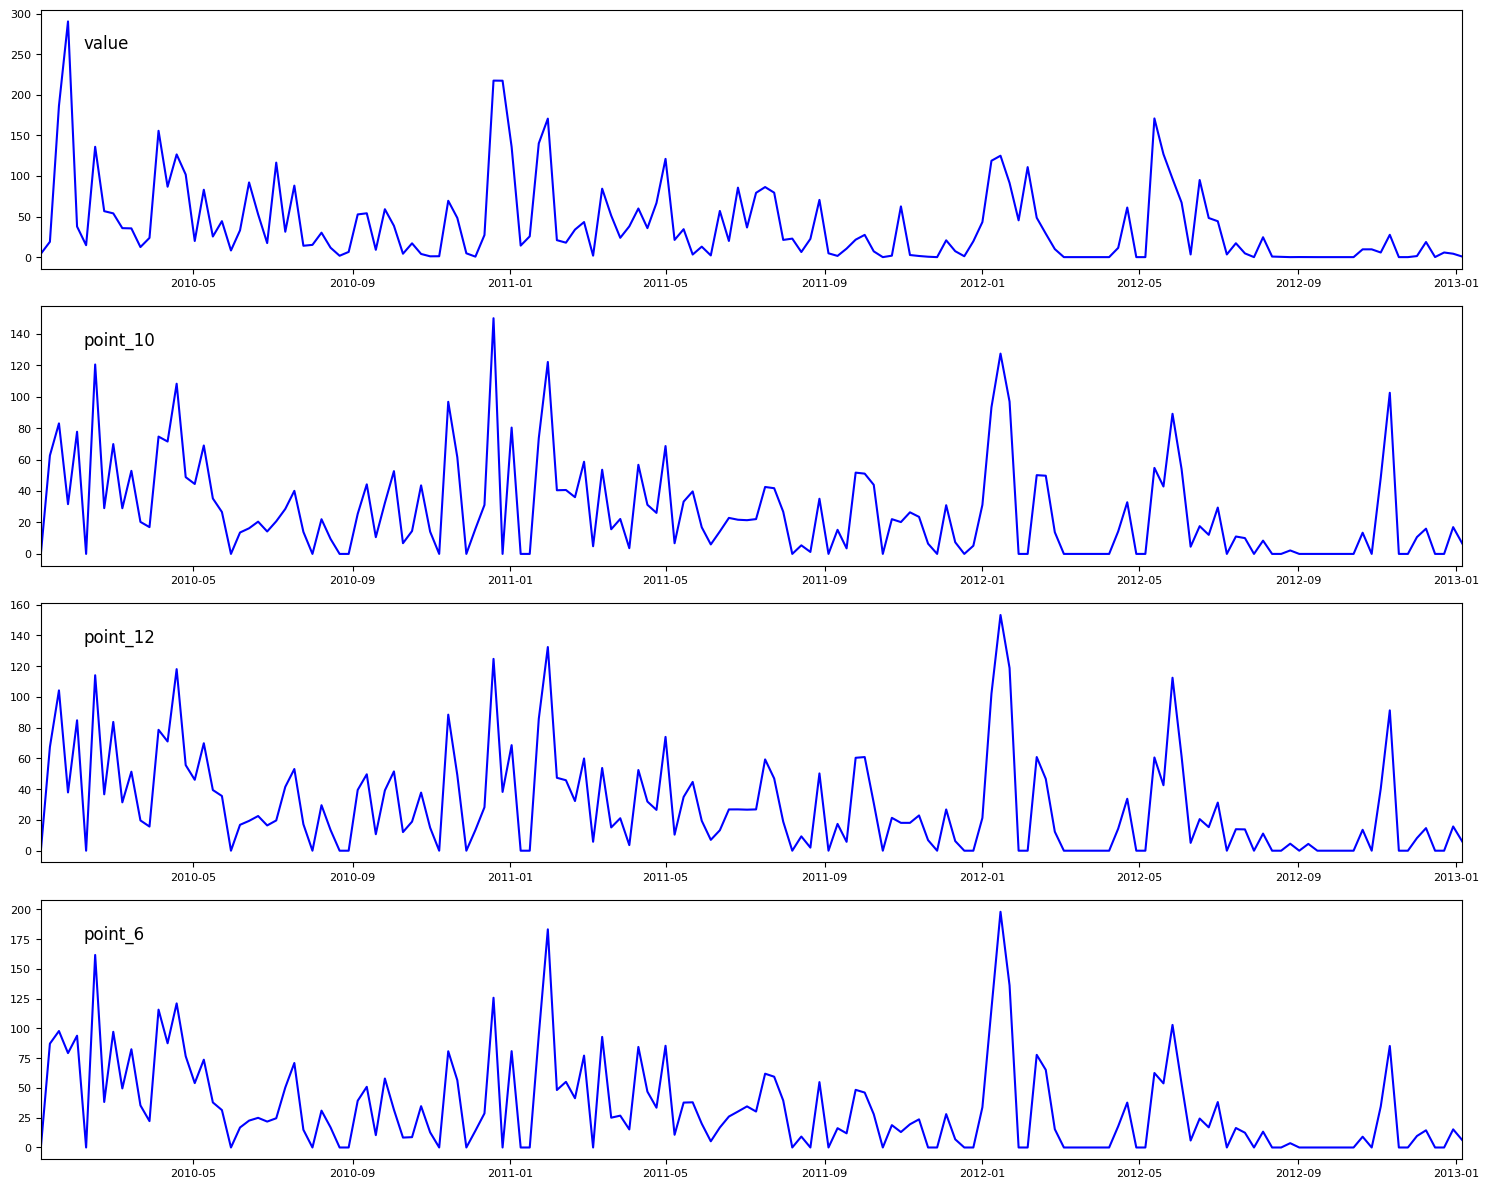

In [14]:

# Muestra cuantas celdas con datos nulos o faltantes tiene cada columna de la base de datos

display(dataset_no_nan.isnull().sum())

dataset_no_nan = dataset_no_nan.resample('W').sum()
# Filtrar solo los valores mayores que 0 en el DataFrame
#estaciones_con_datos = estaciones_con_datos[estaciones_con_datos > 0]
#estaciones_con_datos = estaciones_con_datos[estaciones_con_datos < 1500] # filtro que se coloca por unos datos sospechosos que se intentan comparar toman valores demasiado altos


# Gráficar
fig, axs = plt.subplots(nrows=dataset_no_nan.shape[1], ncols=1, figsize=(15, 12)) # Ajustar el número de "nrows" por el número de columnas a gráficar
for i, col in enumerate(dataset_no_nan.columns[0:]):
    fila = i
    columna = 0
    ax = axs[fila]
    ax.plot(dataset_no_nan.index, dataset_no_nan[col], color='blue')
    ax.set_ylabel('', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_xlim(dataset_no_nan.index.min(), dataset_no_nan.index.max())
    ax.text(0.03, 0.85, col, transform=ax.transAxes, fontsize=12)
plt.subplots_adjust(hspace=0.05)
plt.tight_layout()
plt.show()

- Metodo numerico de correlaciones

Matriz que obtiene los valores cuantitativos de la correlacionde las series del dataset 

- Metodo grafico de correlaciones

Imagen de matriz de correlacion en la cual se aprecian tendencias outliyers y otra clase de informacion alterna de las series

,value,point_10,point_12,point_6
value,1.000000,0.637825,0.677514,0.681934
point_10,0.637825,1.000000,0.976929,0.952675
point_12,0.677514,0.976929,1.000000,0.964672
point_6,0.681934,0.952675,0.964672,1.000000


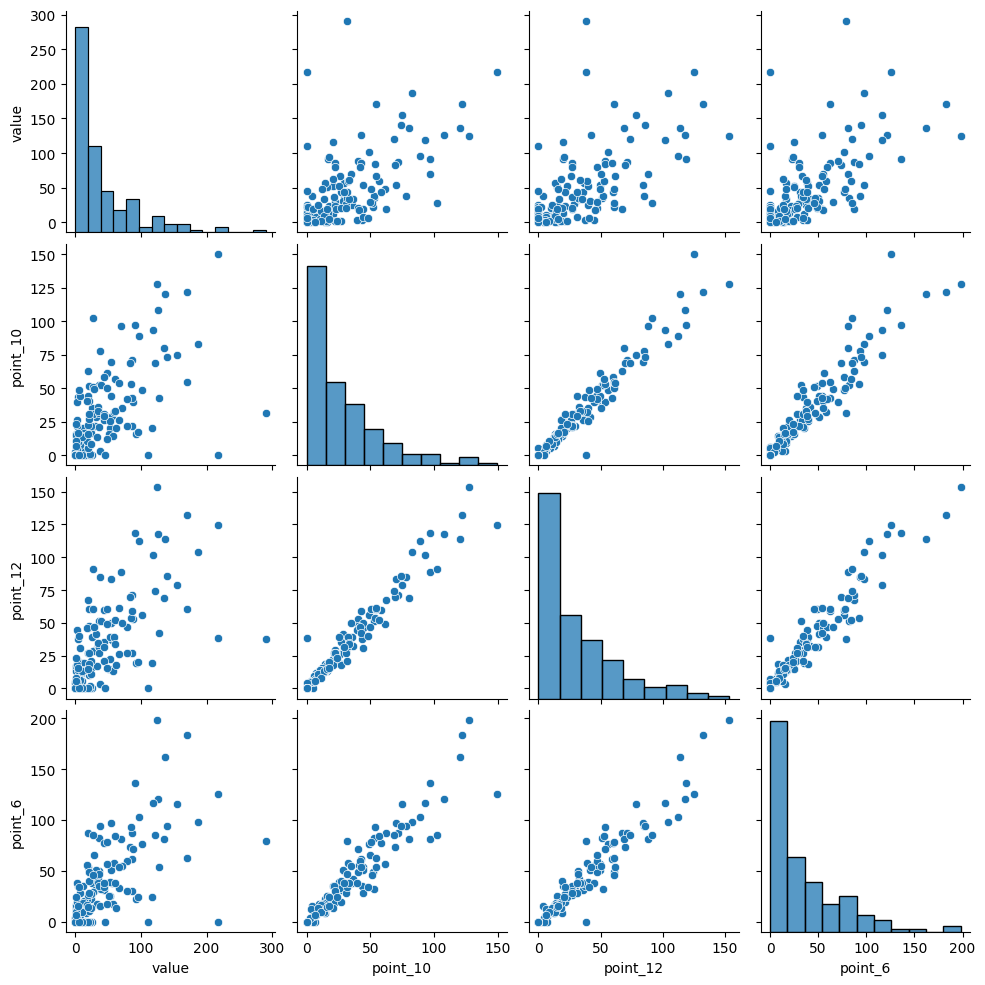

In [15]:
import seaborn as sns 
# Método gráfico de dispersión
sns.pairplot(dataset_no_nan)
# Metodo numerico
dataset_no_nan.corr()

- Matriz de confusion

Con esta analizamos de manera mas legible el estado de las correlaciones que tenemos en el dataset, con esto se analiza la calidad de los datos para la imputacion

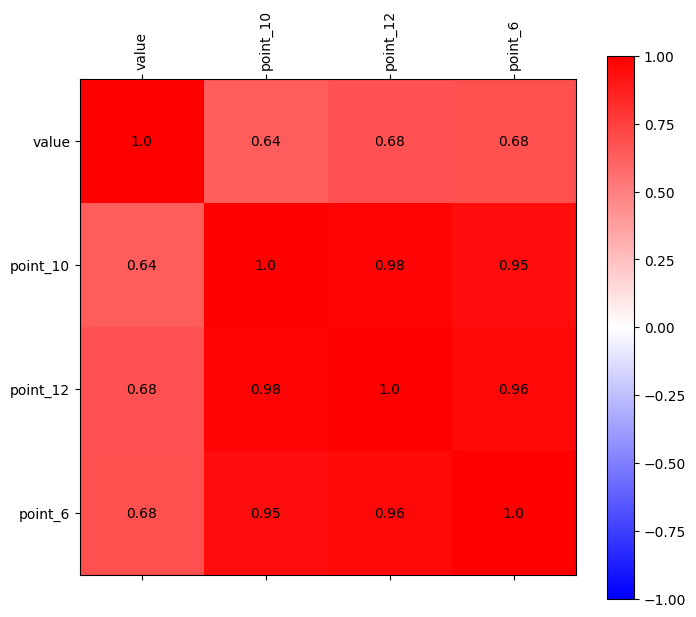

In [16]:
import matplotlib.pyplot as plt

# Calcular la matriz de correlación
matriz = dataset_no_nan.corr()

# Crear la figura de la matriz de correlación
plt.matshow(matriz, cmap="bwr", vmin=-1, vmax=1)

# Configurar etiquetas de los ejes X e Y
plt.xticks(range(len(matriz.columns)), dataset_no_nan.columns, rotation=90)
plt.yticks(range(len(matriz.columns)), dataset_no_nan.columns)

# Agregar los valores de la correlación en cada celda de la matriz
for i in range(len(matriz.columns)):
    for j in range(len(matriz.columns)):
        plt.text(i, j, round(matriz.iloc[i, j], 2), ha="center", va="center", color="black")

# Agregar barra de colores
plt.colorbar()

# Ajustar el tamaño de la figura
plt.gcf().set_size_inches(8, 7)

# Mostrar la matriz de correlación
plt.show()


## **Imputaicon de datos**
---

- Visualizar el estado inicial del *dataset* en cuestrion de valores nulos  y Nan para tener idea de los rellenos 

In [17]:
dataset.isnull().sum()

value       175
point_10      0
point_12      0
point_6       2
dtype: int64

- Creamos el **dataset_model** variable que contiene las tres series que se van a trabajar en el modelo

- Creamos **fechas_con_datos** la cual contiene el df anterior pero eliminando las filas o registros con datos Nan

In [18]:
#Organizamos un dataframe con tres estaciones (2 estaciones para ser predictoras y 1 para ser predecida)
dataset_model = dataset[["point_12", "point_6", "value"]] #ajuste

#Solo se dejan las filas que tengan datos en las tres estaciones
fechas_con_datos = dataset_model.dropna() #ajuste

dataset_model.head(2)

,point_12,point_6,value
timestamp,,,
2010-01-01,0.0,0.0,0.0
2010-01-02,0.0,0.0,0.0


- usamos el modelo de regresion lineal ajustada a los datos con algunas metricas.

In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 1. Cargar y preparar los datos
# Asumiendo que ya tienes tu dataset cargado en `dataset_model`
dataset_model = dataset[["point_12", "point_6", "value"]]
fechas_con_datos = dataset_model.dropna()  # Eliminar filas con valores faltantes

# 2. Normalizar los datos
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(fechas_con_datos)

# 3. Crear secuencias para la LSTM
def create_sequences(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), :-1])  # Usamos point_12 y point_6 como características
        y.append(data[i + time_step, -1])       # Predecimos value
    return np.array(X), np.array(y)

# Definir el tiempo de paso (time_step)
time_step = 10  # Puedes ajustar este valor según la naturaleza de tus datos
X, y = create_sequences(data_scaled, time_step)

# 4. Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Construir el modelo LSTM
model = Sequential()

# Capa LSTM
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Regularización para evitar sobreajuste

# Segunda capa LSTM
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))

# Capa densa de salida
model.add(Dense(1))  # Una neurona para predecir el valor de precipitación

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# 6. Entrenar el modelo
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,  # Número de épocas
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# 7. Evaluar el modelo
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Pérdida en entrenamiento: {train_loss:.4f}")
print(f"Pérdida en prueba: {test_loss:.4f}")

# 8. Hacer predicciones
y_pred = model.predict(X_test)

# 9. Revertir la normalización para obtener valores reales
y_test_actual = scaler.inverse_transform(np.concatenate((X_test[:, -1, :], y_test.reshape(-1, 1)), axis=1))[:, -1]
y_pred_actual = scaler.inverse_transform(np.concatenate((X_test[:, -1, :], y_pred.reshape(-1, 1)), axis=1))[:, -1]

# 10. Calcular métricas de evaluación
from sklearn.metrics import mean_absolute_error, r2_score

mae = mean_absolute_error(y_test_actual, y_pred_actual)
r2 = r2_score(y_test_actual, y_pred_actual)
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

d:\master BigData\01 proyecto final\codigos\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0082 - val_loss: 0.0053
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0107 - val_loss: 0.0053
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0061 - val_loss: 0.0053
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0092 - val_loss: 0.0054
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0098 - val_loss: 0.0054
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0099 - val_loss: 0.0053
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0070 - val_loss: 0.0053
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0095 - val_loss: 0.0053
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0071 - val_loss: 0.0053
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0067 - val_loss: 0.0053
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0079 - val_loss: 0.0054
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


'Correlación entre valores reales y predicciones: 0.19'

'Media real (yTrain):'

6.946905537459283

'Media predicha (yPredict_series):'

6.305263

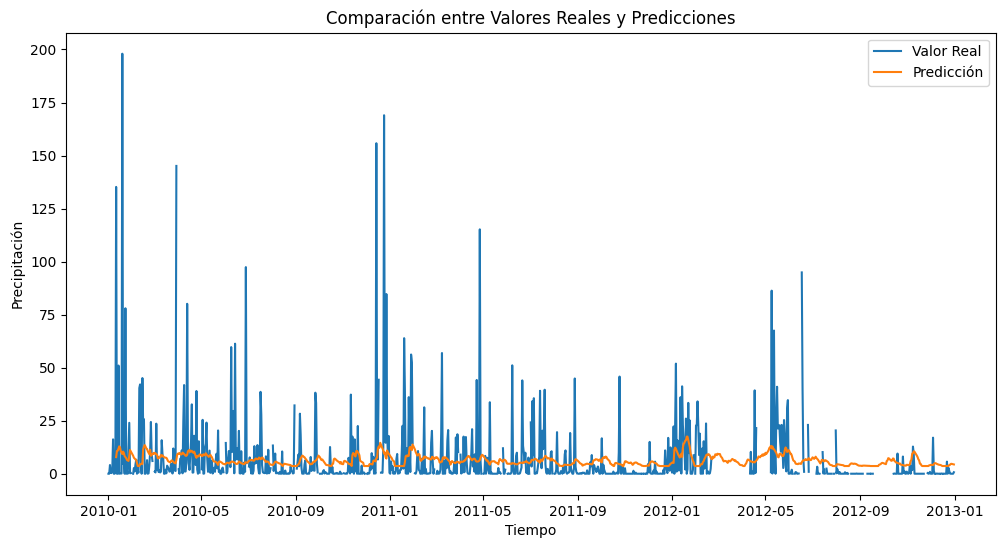

In [26]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 1. Escalado de datos (ajustar solo a las columnas predictoras)
scaler.fit(fechas_con_datos[['point_12', 'point_6']])  # Ajustar solo a las columnas predictoras

# 2. Preparar los datos de prueba (xTest)
xTest = dataset[["point_12", "point_6"]].dropna()  # Usamos las mismas columnas predictoras
xTest_scaled = scaler.transform(xTest)  # Escalar los datos de prueba

# 3. Crear secuencias para la LSTM (igual que en el entrenamiento)
def create_sequences_test(data, time_step=10):
    X_test_seq = []
    for i in range(len(data) - time_step):
        X_test_seq.append(data[i:(i + time_step), :])  # Usamos todas las columnas (point_12 y point_6)
    return np.array(X_test_seq)

# Crear secuencias para xTest
xTest_sequences = create_sequences_test(xTest_scaled, time_step=10)

# 4. Realizar la predicción con el modelo LSTM
yPredict = model.predict(xTest_sequences)

# 5. Revertir la normalización de las predicciones
# Para revertir la normalización, necesitamos concatenar las predicciones con las características originales
# y luego aplicar la inversa del escalador.
# Nota: Aquí asumimos que el escalador no afecta a la columna "value", ya que no se incluyó en el ajuste.
yPredict_actual = yPredict * (dataset_model["value"].max() - dataset_model["value"].min()) + dataset_model["value"].min()

# 6. Convertir yPredict_actual a una serie de pandas con el índice correspondiente
yPredict_series = pd.Series(yPredict_actual.flatten(), index=xTest.index[time_step:])

# 7. Calcular la correlación entre los valores reales y las predicciones
# Asegurarse de que los índices coincidan
corr_value = dataset_model["value"].loc[yPredict_series.index].corr(yPredict_series)

# Mostrar la correlación
display(f"Correlación entre valores reales y predicciones: {corr_value:.2f}")
display("Media real (yTrain):", dataset_model["value"].mean())
display("Media predicha (yPredict_series):", yPredict_series.mean())

# 8. Comparación gráfica de la estación "value" y las predicciones
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(dataset_model.index, dataset_model["value"], label="Valor Real")  # Valores reales
ax.plot(yPredict_series.index, yPredict_series, label='Predicción')  # Predicciones
plt.legend()
plt.title("Comparación entre Valores Reales y Predicciones")
plt.xlabel("Tiempo")
plt.ylabel("Precipitación")
plt.show()

In [32]:
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import numpy as np
import tensorflow as tf

# 1. Definir una función para crear el modelo de Keras
def create_model(n_units=64, dropout_rate=0.2, learning_rate=0.01, dropout_rate=0.2, epochs=50, batch_size=64):
    model = Sequential()
    model.add(LSTM(n_units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(n_units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='mean_squared_error')
    return model

# 2. Envolver el modelo de Keras en un KerasRegressor de scikeras
keras_regressor = KerasRegressor(model=create_model, verbose=0)

# 3. Definir la distribución de hiperparámetros para la búsqueda aleatoria
param_dist = {
    'model__n_units': [32, 64, 128],  # Número de unidades en las capas LSTM
    'model__dropout_rate': [0.1, 0.2, 0.3],  # Tasa de dropout
    'model__learning_rate': [0.001, 0.01, 0.1],  # Tasa de aprendizaje
    'batch_size': [16, 32, 64],  # Tamaño del lote
    'epochs': [50, 100, 200]  # Número de épocas
}

# 4. Realizar la búsqueda aleatoria
random_search = RandomizedSearchCV(
    estimator=keras_regressor,
    param_distributions=param_dist,
    n_iter=10,  # Número de combinaciones de hiperparámetros a probar
    cv=3,  # Número de divisiones para la validación cruzada
    random_state=42,
    n_jobs=-1  # Usar n_jobs=1 para evitar problemas con Keras
)

# 5. Ajustar el modelo con la búsqueda aleatoria
random_search.fit(X_train, y_train)

# 6. Mostrar los mejores parámetros y la mejor puntuación
print(f"Mejores parámetros aleatorios: {random_search.best_params_}")
print(f"Mejor puntuación aleatoria: {random_search.best_score_:.2f}")

d:\master BigData\01 proyecto final\codigos\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Mejores parámetros aleatorios: {'model__n_units': 64, 'model__learning_rate': 0.01, 'model__dropout_rate': 0.2, 'epochs': 50, 'batch_size': 64}
Mejor puntuación aleatoria: 0.01


- Se crea una predicion de la serie temporal basada en una de las variables completas, para ello se utiliza un escalador para normalizar los datos y redes neuronales para generar el modelo

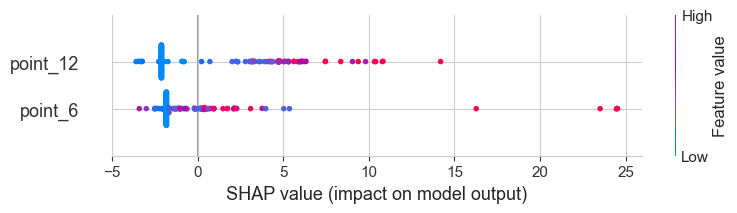

C:\Users\dreng\AppData\Local\Temp\ipykernel_21968\1224554040.py:40: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




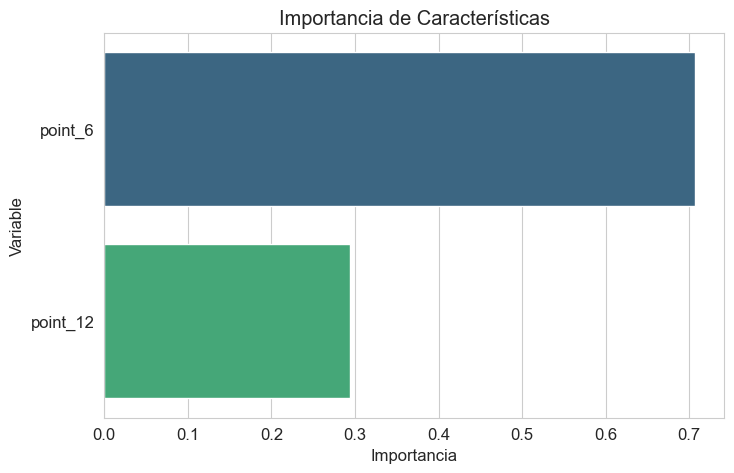

MAE: 8.78
RMSE: 20.30
R²: 0.16


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

'''# 1. Calcular errores
errors = y_test - y_pred

# 2. Graficar distribución de errores
plt.figure(figsize=(12, 5))
sns.histplot(errors, bins=30, kde=True, color="red")
plt.axvline(errors.mean(), color='black', linestyle='dashed', linewidth=2, label=f"Media: {errors.mean():.2f}")
plt.xlabel("Error")
plt.ylabel("Frecuencia")
plt.title("Distribución de Errores")
plt.legend()
plt.show()

# 3. Gráfico de dispersión: valores reales vs. predichos
plt.figure(figsize=(12, 5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2)  # Línea ideal
plt.xlabel("Valores Reales")
plt.ylabel("Valores Predichos")
plt.title("Valores Reales vs. Predichos")
plt.show()
'''
import shap

# Crear un explainer de SHAP
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Gráfico de importancia de características con SHAP
plt.figure(figsize=(10, 5))
shap.summary_plot(shap_values, X_test)

plt.figure(figsize=(8, 5))
sns.barplot(x="Importance", y="Feature", data=feature_importances, palette="viridis")
plt.title("Importancia de Características")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.show()

# 5. Mostrar métricas
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")


In [32]:
#test
from scipy.stats import spearmanr

corr_12_6_spearman, _ = spearmanr(X['point_12'], X['point_6'])
print(f"Correlación de Spearman entre point_12 y point_6: {corr_12_6_spearman:.2f}")

from statsmodels.tsa.stattools import adfuller

result = adfuller(dataset['value'].dropna())
print(f"Estadística ADF: {result[0]:.4f}")
print(f"P-valor: {result[1]:.4f}")
print(f"Valor crítico (1%): {result[4]['1%']:.4f}")


Correlación de Spearman entre point_12 y point_6: 0.90
Estadística ADF: -7.3019
P-valor: 0.0000
Valor crítico (1%): -3.4375


MAE: 8.7823
RMSE: 20.2979
R²: 0.1566
R² de validación cruzada: 0.0669


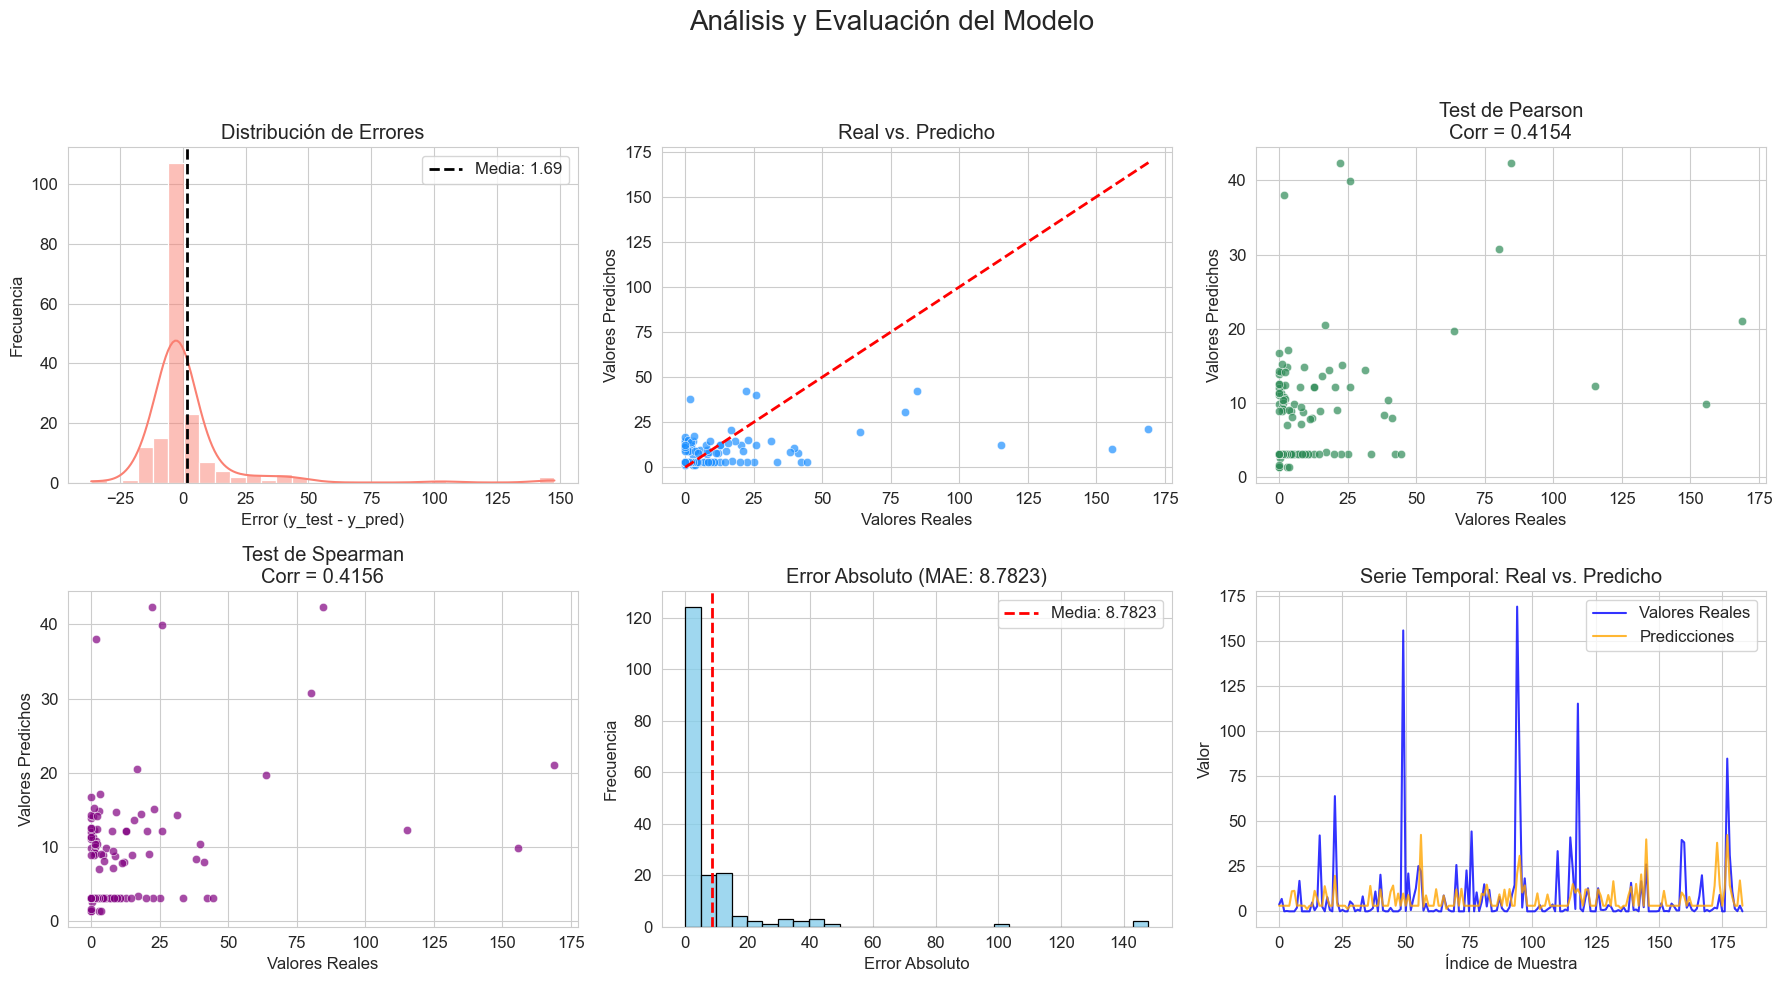

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
import shap
import plotly.graph_objects as go
from scipy.stats import pearsonr, spearmanr

# ============================
# CONFIGURACIÓN Y CÁLCULOS INICIALES
# ============================

# (Asegúrate de tener definidas las variables: X_train, X_test, y_test, y_pred y model)

# Calcular errores y métricas de desempeño
errors = y_test - y_pred
abs_error = np.abs(errors)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
cross_val_scores = cross_val_score(model, X, y, cv=5, scoring='r2') # Validación cruzada para obtener el R² promedio

# Mostrar las métricas calculadas
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")
print(f"R² de validación cruzada: {cross_val_scores.mean():.4f}")

# Calcular el explainer y los valores SHAP para la interpretación del modelo
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Calcular la importancia promedio de cada característica (valor absoluto promedio)
shap_importance = np.abs(shap_values.values).mean(axis=0)
features = X_test.columns

# ============================
# VISUALIZACIÓN CON MATPLOTLIB Y SEABORN
# ============================
# Configurar estilo de Seaborn
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12})

# Creamos un dashboard en Matplotlib con 2 filas y 3 columnas
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle("Análisis y Evaluación del Modelo", fontsize=20, y=0.98)

# --- 1. Distribución de errores (con signo) ---
ax = axs[0, 0]
sns.histplot(errors, bins=30, kde=True, color="salmon", ax=ax)
ax.axvline(errors.mean(), color='black', linestyle='dashed', linewidth=2, label=f"Media: {errors.mean():.2f}")
ax.set_xlabel("Error (y_test - y_pred)")
ax.set_ylabel("Frecuencia")
ax.set_title("Distribución de Errores")
ax.legend()

# --- 2. Gráfico de dispersión: Valores Reales vs. Predichos ---
ax = axs[0, 1]
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7, color="dodgerblue", ax=ax)
# Línea de referencia ideal: predicción perfecta
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2)
ax.set_xlabel("Valores Reales")
ax.set_ylabel("Valores Predichos")
ax.set_title("Real vs. Predicho")

# --- 3. Test de Pearson ---
pearson_corr, _ = pearsonr(y_test, y_pred)
ax = axs[0, 2]
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7, color="seagreen", ax=ax)
ax.set_xlabel("Valores Reales")
ax.set_ylabel("Valores Predichos")
ax.set_title(f"Test de Pearson\nCorr = {pearson_corr:.4f}")

# --- 4. Test de Spearman ---
spearman_corr, _ = spearmanr(y_test, y_pred)
ax = axs[1, 0]
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7, color="purple", ax=ax)
ax.set_xlabel("Valores Reales")
ax.set_ylabel("Valores Predichos")
ax.set_title(f"Test de Spearman\nCorr = {spearman_corr:.4f}")

# --- 5. Distribución del error absoluto ---
ax = axs[1, 1]
sns.histplot(abs_error, bins=30, edgecolor='black', color="skyblue", alpha=0.8, ax=ax)
ax.axvline(abs_error.mean(), color='red', linestyle='dashed', linewidth=2, label=f"Media: {abs_error.mean():.4f}")
ax.set_xlabel("Error Absoluto")
ax.set_ylabel("Frecuencia")
ax.set_title(f"Error Absoluto (MAE: {mae:.4f})")
ax.legend()

# --- 6. Comparación secuencial: Predicción vs. Real a lo largo de las muestras ---
ax = axs[1, 2]
indices = np.arange(len(y_test))
ax.plot(indices, y_test, label='Valores Reales', linestyle='-', color="blue", alpha=0.8)
ax.plot(indices, y_pred, label='Predicciones', linestyle='-', color="orange", alpha=0.8)
ax.set_xlabel("Índice de Muestra")
ax.set_ylabel("Valor")
ax.set_title("Serie Temporal: Real vs. Predicho")
ax.legend()

# Ajuste final de los subplots
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Reserva espacio para el título principal
plt.show()

# ============================
# VISUALIZACIÓN INTERACTIVA CON PLOTLY: IMPORTANCIA DE CARACTERÍSTICAS (SHAP)
# ============================
# Creamos un gráfico de barras interactivo con Plotly
shap_fig = go.Figure(data=[go.Bar(
    x=shap_importance,
    y=features,
    orientation='h',
    marker=dict(color="green")
)])
shap_fig.update_layout(
    title="Importancia de Características (Promedio de Valores SHAP)",
    xaxis_title="Importancia (Valor Absoluto Promedio)",
    yaxis_title="Características",
    height=500,
    template="plotly_white"
)
shap_fig.show()


In [35]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Suponiendo que ya tienes el modelo RandomForest 'regr' entrenado y el scaler ajustado

# Crear una nueva columna para los valores predichos
dataset_model["value_complet"] = 0  # Crear columna vacía para los valores completados
display(dataset_model)


'''# Ajustar la media
ajuste = dataset_model['value_complet'].mean() - dataset_model['value'].mean()
dataset_model['value_complet'] = dataset_model['value_complet'] - ajuste'''

# Escalar las columnas de las estaciones predictoras
scaler = StandardScaler()
scaler.fit(dataset_model[['point_12', 'point_6']])

# Reemplazar valores faltantes usando el modelo RandomForest
for index, row in dataset_model.iterrows():
    if np.isnan(row["value"]) and ~np.isnan(row["point_12"]) and ~np.isnan(row["point_6"]): 
        # Si el valor está ausente y las estaciones predictoras tienen datos
        row_scaled = scaler.transform([[row["point_12"], row["point_6"]]])  # Escalar las estaciones
        dataset_model.loc[index, ["value_complet"]] = model.predict(row_scaled)  # Predecir el valor faltante
    elif ~np.isnan(row["value"]):  
        # Si el valor ya está presente, dejarlo intacto
        dataset_model.loc[index, ["value_complet"]] = row["value"]
    else:
        # Si hay datos faltantes en todas las columnas, asignar NaN
        dataset_model.loc[index, ["value_complet"]] = np.nan

# Mostrar los promedios
print(f'Promedio Real: {dataset_model["value"].mean():.2f}')
print(f'Promedio Modelo: {dataset_model["value_complet"].mean():.2f}')

,point_12,point_6,value,value_complet
timestamp,,,,
2010-01-01,0.000000,0.000000,0.0,0
2010-01-02,0.000000,0.000000,0.0,0
2010-01-03,0.000000,0.000000,4.1,0
2010-01-04,0.000000,0.000000,0.4,0
2010-01-05,0.000000,0.000000,0.3,0
...,...,...,...,...
2012-12-27,0.000000,0.000000,0.0,0
2012-12-28,0.000000,0.000000,0.0,0
2012-12-29,0.000000,0.000000,0.0,0


C:\Users\dreng\AppData\Local\Temp\ipykernel_21968\1397441617.py:28: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

d:\master BigData\01 proyecto final\codigos\venv\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

d:\master BigData\01 proyecto final\codigos\venv\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names

d:\master BigData\01 proyecto final\codigos\venv\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

d:\master BigData\01 proyecto final\codigos\venv\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature nam

Promedio Real: 6.95
Promedio Modelo: 6.29


d:\master BigData\01 proyecto final\codigos\venv\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

d:\master BigData\01 proyecto final\codigos\venv\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names



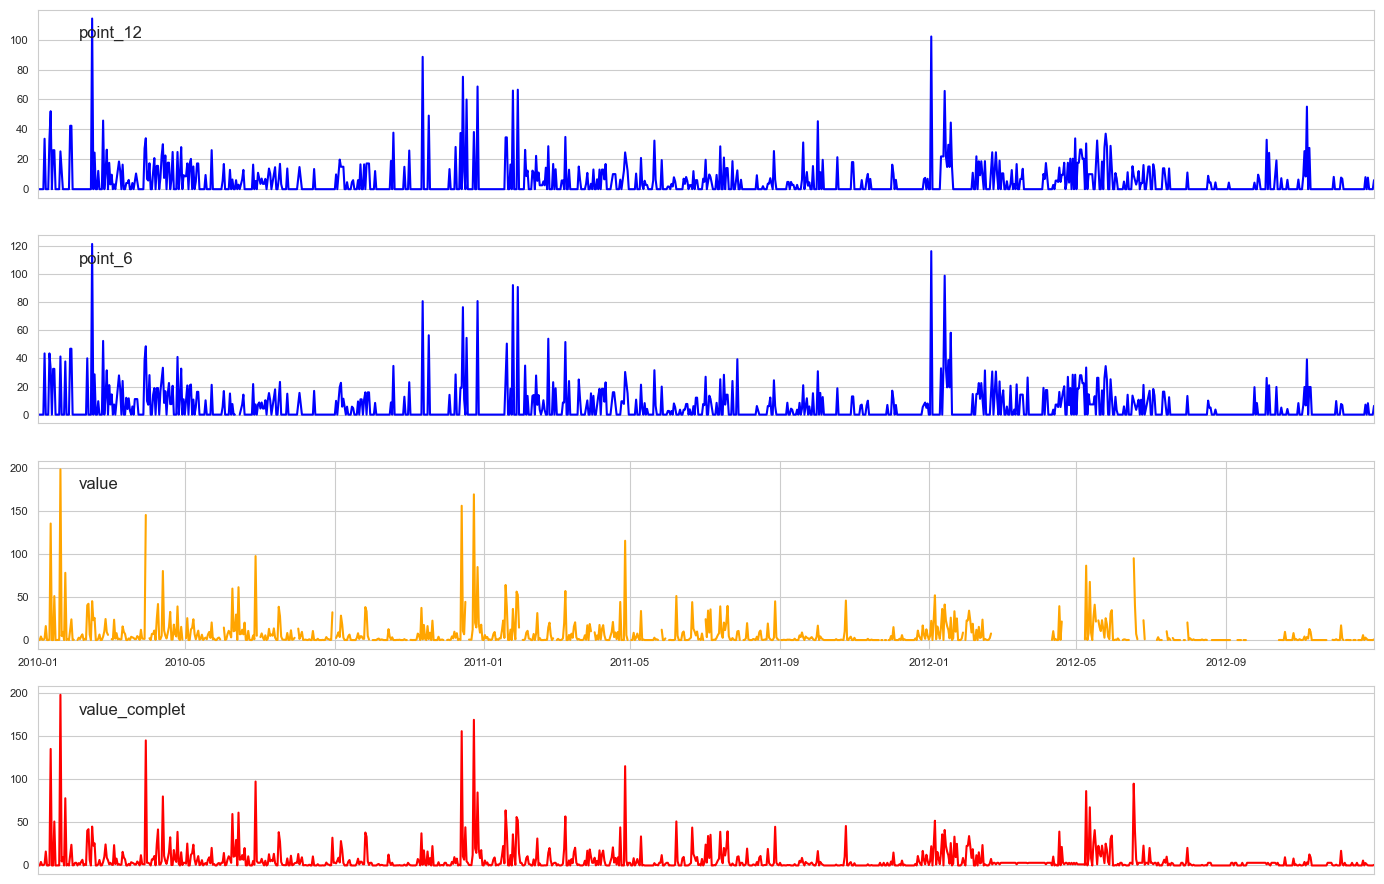

In [36]:
#Gráfica
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(14, 9)) # Ajustar el número de "nrows" por el número de columnas a gráficar
colores = ['blue', 'blue', 'orange', 'red']
for i, col in enumerate(dataset_model.columns[0:]):
    fila = i
    columna = 0
    ax = axs[fila]
    ax.plot(dataset_model.index, dataset_model[col], color=colores[i%len(colores)])
    ax.set_ylabel('', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_xlim(dataset_model.index.min(), dataset_model.index.max())
    ax.text(0.03, 0.85, col, transform=ax.transAxes, fontsize=12)
    if i != len(dataset_model.columns[1:]) - 1:
        ax.set_xticks([])
    else:
        ax.set_xlabel('', fontsize=6)
plt.subplots_adjust(hspace=0.05)
plt.tight_layout()
plt.show()

In [37]:
from graphics_utils.go import multi_line

fig = multi_line(original=dataset_model['value'], Recostruccion = dataset_model['value_complet'])
fig.show()

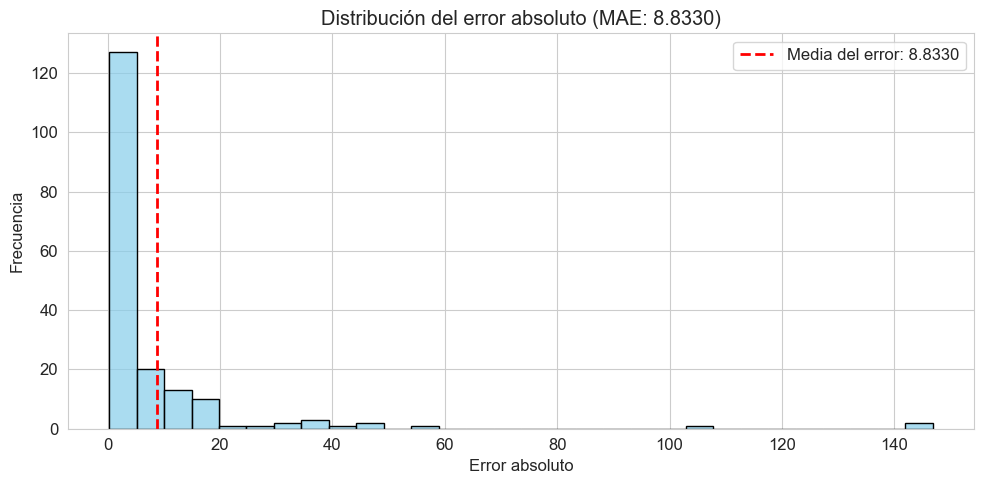

KeyError: 'Real'

<Figure size 1200x600 with 0 Axes>

In [28]:
# --- Gráficos de evaluación y análisis ---

# 1. Calcular el error absoluto
error = np.abs(y_test - y_pred)

# Calcular el MAE para los gráficos (ya calculado antes)
# Configurar el estilo de los gráficos
sns.set_style("whitegrid")

# --- 2. Gráfico del error absoluto ---
plt.figure(figsize=(10, 5))
sns.histplot(error, bins=30, edgecolor='black', color="skyblue", alpha=0.7)
plt.axvline(error.mean(), color='red', linestyle='dashed', linewidth=2,
            label=f'Media del error: {error.mean():.4f}')
plt.xlabel("Error absoluto")
plt.ylabel("Frecuencia")
plt.title(f"Distribución del error absoluto (MAE: {mae:.4f})")
plt.legend()
plt.tight_layout()
plt.show()

# --- 3. Comparación de predicción vs. real ---
plt.figure(figsize=(12, 6))
# Usamos np.arange para mayor claridad
indices = np.arange(len(dataset_model['Real']))
plt.plot(indices, dataset_model['Real'], label='Valores Reales', linestyle='-', alpha=0.7)
plt.plot(indices, dataset_model['Predicted'], label='Predicciones', linestyle='-', alpha=0.7)
plt.xlabel("Índice de muestra")
plt.ylabel("Valor")
plt.title("Comparación entre valores reales y predicciones")
plt.legend()
plt.tight_layout()
plt.show()

# --- 4. Gráfico de dispersión: Real vs. Predicho ---
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5, edgecolors='black')
# Línea ideal: donde las predicciones serían perfectas
min_val, max_val = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='dashed')
plt.xlabel("Valores Reales")
plt.ylabel("Valores Predichos")
plt.title("Gráfico de dispersión: Real vs. Predicho")
plt.tight_layout()
plt.show()